<a href="https://colab.research.google.com/github/sanjaynagi/primerDesignAg/blob/main/Primer-Design-in-Anopheles-gambiae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, install some packages we require
!pip install agamPrimer==0.1.6 primer3-py malariagen_data scikit-allel -q 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 397 kB 5.2 MB/s 
     |████████████████████████████████| 62 kB 496 kB/s 
     |████████████████████████████████| 5.7 MB 26.9 MB/s 
     |████████████████████████████████| 2.3 MB 54.1 MB/s 
     |████████████████████████████████| 140 kB 60.1 MB/s 
     |████████████████████████████████| 3.3 MB 55.2 MB/s 
     |████████████████████████████████| 185 kB 71.9 MB/s 
     |████████████████████████████████| 300 kB 65.7 MB/s 
     |████████████████████████████████| 1.1 MB 44.9 MB/s 
     |████████████████████████████████| 271 kB 50.6 MB/s 
     |████████████████████████████████| 144 kB 60.8 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 6.6 MB 36.4 MB/s 


In [ ]:
# Import libraries 
import agamPrimer
import pandas as pd 
import allel 
import malariagen_data
import numpy as np
import primer3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches

#**Primer design incorporating genetic variation in *Anopheles gambiae***
**Author**: [Sanjay Curtis Nagi](https://sanjaynagi.github.io/)    
**Email**: sanjay.nagi@lstmed.ac.uk

Often, we would like to design primers for PCR applications, such as genotyping (PCR, TaqMan, LNA) or gene expression qPCR (SYBR, TaqMan, LNA). However, single nucleotide polymorphisms (SNPs) in primer binding sites can result in differences or failures in PCR amplification, referred to as null alleles. 

In general, mismatches caused by SNPs are more of a problem as you move towards the 3' end. I recommend reading a really good article on this topic on the IDT website - [Consider SNPs when designing PCR and qPCR assays](https://eu.idtdna.com/pages/education/decoded/article/considering-snps-when-designing-pcr-and-qpcr-assays). In *An. gambiae s.l*, there is a [huge amount of genetic variation](https://genome.cshlp.org/content/30/10/1533.full); a SNP found approximately every 1.9 bases (!), which makes considering SNPs even more important when designing molecular assays. Thanks to primer3-py and the fantastic malariagen_data package, we can do all of this in the cloud, hosted by google!


####**Google Colab**

If you are unfamiliar with iPython notebooks and google colab, I encourage you to watch the following [introduction](https://www.youtube.com/watch?v=inN8seMm7UI). In general, the cells can be run by pressing the play button next to each cell, and should be run in order.

In [ ]:
#@title **Selecting Primer Parameters** { run: "auto" }
#@markdown In the below cells, replace the values with those desired for your primers. Unless you wish to use custom primer3 parameters, there is no need to edit any other cells in the notebook. 

assay_type = 'gDNA'           #@param ["gDNA", "qPCR"]
assay_name = 'coeae1f'              #@param {type:"string"}
min_amplicon_size = 50        #@param {type:"integer"}
max_amplicon_size = 100       #@param {type:"integer"}
amplicon_size_range = [[min_amplicon_size, max_amplicon_size]]
n_primer_pairs = 8            #@param {type:"slider", min:1, max:20, step:1}

#@markdown    
#@markdown target_loc is required for gDNA primers, and transcript required for qPCR primers.
contig =  "2L"                #@param {type:"string"}

target_loc =            28545787#@param {type:"integer"}
transcript =  'AGAP006227-RA'         #@param {type:"string"} 


if assay_type == 'gDNA':
  assert target_loc > 0, "Target location must be above 0 and less than the contig length"
elif assay_type == 'qPCR':
  assert len(transcript) > 2, "Transcript ID is not valid, should be vectorbase ID such as 'AGAP004707-RD'"

Load sequence data for chromosomal arm of choice, using the [malariagen_data API](https://malariagen.github.io/vector-data/ag3/api.html):

In [ ]:
# Connect to the malariagen_data ag3 API
ag3 = malariagen_data.Ag3() #pre=True
genome_seq = ag3.genome_sequence(region=contig)
print(f"Our genome sequence for {contig} is {genome_seq.shape[0]} bp long")

Our genome sequence for 2L is 49364325 bp long


Now we need to extract the bit of sequence we need. We will use functions in the [agamPrimer](https://pypi.org/project/agamPrimer/) package.

In [ ]:
if assay_type == 'gDNA':
  # genomic DNA
  target_sequence, target_loc_primer3, gdna_pos = agamPrimer.prepare_gDNA_sequence(target_loc=target_loc, amplicon_size_range=amplicon_size_range, genome_seq=genome_seq)
elif assay_type == 'qPCR':
  # quantitative PCR 
  target_sequence, exon_junctions, gdna_pos = agamPrimer.prepare_cDNA_sequence(transcript=transcript, gff=ag3.geneset(), genome_seq=genome_seq)

The target sequence is 150 bases long
the target snp is 74 bp into our target sequence


Now we have our target sequence. Lets take a look...

In [ ]:
target_sequence

'CCAACACTGCCGCCAACATTCGGGCTGCCCACGGTCGCAAAGTTAGTAAACAACTCGACCTATTGCGAAATGTTCCTTTAGAGTGTTTTCCAAATACTACGCAAACACTACGCAAACCATACTACTTACCAGCGTTTGCATCGTCCTGTA'

We need to set up some python dictionaries containing our sequence and primer parameters, this will be our input to primer3. In the below cell, you can modify or add primer3 parameters, such as optimal TM, GC content etc etc. A full list of possible parameters and their functions can be found in the [primer3 manual](https://primer3.org/manual.html).

In [ ]:
seq_parameters = {
        'SEQUENCE_ID': assay_name,
        'SEQUENCE_TEMPLATE': target_sequence,
    }

# need to add either target location for DNA or exon junctions for qPCR
if assay_type == 'gDNA':
  seq_parameters['SEQUENCE_TARGET'] = target_loc_primer3
elif assay_type == 'qPCR':
  seq_parameters['SEQUENCE_OVERLAP_JUNCTION_LIST'] = exon_junctions  
    
primer_parameters  =  {
        'PRIMER_NUM_RETURN':n_primer_pairs,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_PICK_RIGHT_PRIMER':1,
        'PRIMER_PICK_INTERNAL_OLIGO': 0, 
        'PRIMER_PICK_LEFT_PRIMER':1,
        'PRIMER_TASK':'generic',
        'PRIMER_MIN_SIZE': 17,
        'PRIMER_MAX_SIZE': 24,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 57.0,
        'PRIMER_MAX_TM': 63.0,
        'PRIMER_MIN_GC': 30.0,
        'PRIMER_MAX_GC': 75.0,
        'PRIMER_PRODUCT_SIZE_RANGE': amplicon_size_range,
        'PRIMER_EXPLAIN_FLAG':1,
        'PRIMER_MIN_THREE_PRIME_DISTANCE':3   
        # Extra primer3 parameters can go here
        # In the exact same format as above                       
    }

#### **Run the primer3 algorithm!**

In [ ]:
primer_dict = primer3.designPrimers(seq_args=seq_parameters, global_args=primer_parameters)

It should be *very fast*. The output, which we call 'primer_dict', is a python dictionary containing the full results from primer3. We will turn this into a pandas dataframe (i.e a useful, pretty table), containing just the necessary bits of information. First, we'll print some information from the primer3 run. The first 7 rows of the data frame are general statistics from the run, like the number of primer pairs considered and failed:

In [ ]:
primer_df = pd.DataFrame.from_dict(primer_dict.items())          # Convert the dict into a pandas dataframe
primer_df = primer_df.rename(columns={0:'parameter', 1:'value'}) # Rename the columns
explanations_df = primer_df.iloc[:7, :]                          # Take the first 7 rows which are general

for idx, row in explanations_df.iterrows():                      # Loop through each row and print information
    print(row['parameter'], " : ", row['value'], "\n")

PRIMER_LEFT_EXPLAIN  :  considered 436, GC content failed 15, low tm 152, high tm 157, ok 112 

PRIMER_RIGHT_EXPLAIN  :  considered 372, low tm 211, high tm 16, ok 145 

PRIMER_PAIR_EXPLAIN  :  considered 798, unacceptable product size 789, primer in pair overlaps a primer in a better pair 802, ok 9 

PRIMER_LEFT_NUM_RETURNED  :  5 

PRIMER_RIGHT_NUM_RETURNED  :  5 

PRIMER_INTERNAL_NUM_RETURNED  :  0 

PRIMER_PAIR_NUM_RETURNED  :  5 



Now lets wrangle this into an easy to look at table.

In [ ]:
# Create a column which is primer pair #, and a column for primer parameter which does not contain primer pair #
primer_df = primer_df.iloc[7:, :].copy()
primer_df['primer_pair'] = primer_df['parameter'].str.extract("([0-9][0-9]|[0-9])")
primer_df['parameter'] = primer_df['parameter'].str.replace("(_[0-9][0-9]|_[0-9])", "", regex=True)

# Put the different primer pairs in different columns
primer_df = primer_df.pivot(index='parameter', columns='primer_pair', values='value')

# Get a list of the rows we need 
primer_span = ['PRIMER_LEFT', 'PRIMER_RIGHT']
required_info = ['SEQUENCE', 'TM', 'GC_PERCENT']
required_info = [p + "_" + y for y in required_info for p in primer_span] + primer_span + ['PRIMER_PAIR_PRODUCT_SIZE']

# Subset data frame
primer_df = primer_df.loc[required_info, np.arange(primer_df.shape[1]).astype(str)]
primer_df

primer_pair,0,1,2,3,4
parameter,,,,,
PRIMER_LEFT_SEQUENCE,CCCACGGTCGCAAAGTTAGT,ACTCGACCTATTGCGAAATGT,ACAACTCGACCTATTGCGAA,CCACGGTCGCAAAGTTAGTAAA,AACATTCGGGCTGCCCAC
PRIMER_RIGHT_SEQUENCE,TGGTTTGCGTAGTGTTTGCG,TACAGGACGATGCAAACGCT,GACGATGCAAACGCTGGTAA,TTGCGTAGTGTTTGCGTAGT,TGCGTAGTGTTTGCGTAGTATT
PRIMER_LEFT_TM,60.601841,57.752994,57.263856,59.198321,60.676471
PRIMER_RIGHT_TM,59.971758,60.037697,59.206139,58.144487,58.422333
PRIMER_LEFT_GC_PERCENT,55.0,42.857143,45.0,45.454545,61.111111
PRIMER_RIGHT_GC_PERCENT,50.0,50.0,50.0,45.0,40.909091
PRIMER_LEFT,"(27, 20)","(52, 21)","(49, 20)","(28, 22)","(14, 18)"
PRIMER_RIGHT,"(118, 20)","(149, 20)","(144, 20)","(114, 20)","(113, 22)"
PRIMER_PAIR_PRODUCT_SIZE,92,98,96,87,100



We can write this to a .tsv file, which can be stored and explored in other editors if necessary. To download a file from colab to your local computer, click the folder panel on the left-hand sidebar, the three dots next your primers.tsv file, and download.

In [ ]:
primer_df.to_csv(f"{assay_name}.{assay_type}.primers.tsv", sep="\t")

##**Looking for variation using the ag1000g resource and malariagen API**

In Ag3, samples are organised into sample sets. We can load any sample set from the Ag3 resource, but there are quite a few! Lets look at what each sample set contains, breaking it down by species, year and country. 

In [ ]:
metadata = ag3.sample_metadata()

Load sample metadata:   0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
pivot_country_year_taxon = (
    metadata
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0
    )
)

pivot_country_year_taxon

taxon                                                arabiensis  coluzzii  \
sample_set   year  country                                                  
AG1000G-AO    2009 Angola                                     0        81   
AG1000G-BF-A  2012 Burkina Faso                               0        82   
AG1000G-BF-B  2014 Burkina Faso                               3        53   
AG1000G-BF-C  2004 Burkina Faso                               0         0   
AG1000G-CD    2015 Democratic Republic of the Congo           0         0   
AG1000G-CF    1993 Central African Republic                   0         5   
              1994 Central African Republic                   0        13   
AG1000G-CI    2012 Cote d'Ivoire                              0        80   
AG1000G-CM-A  2009 Cameroon                                   0         0   
AG1000G-CM-B  2005 Cameroon                                   0         7   
AG1000G-CM-C  2013 Cameroon                                   2        19   
AG1000G-FR    2011 Mayotte                                    0         0   
AG1000G-GA-A  2000 Gabon                                      0         0   
AG1000G-GH    2012 Ghana                                      0        64   
AG1000G-GM-A  2011 Gambia, The                                0         0   
AG1000G-GM-B  2012 Gambia, The                                0         2   
AG1000G-GM-C  2012 Gambia, The                                0        12   
AG1000G-GN-A  2012 Guinea                                     0         4   
AG1000G-GN-B  2012 Guinea                                     0         7   
                   Mali                                       0        28   
AG1000G-GQ    2002 Equatorial Guinea                          0         0   
AG1000G-GW    2010 Guinea-Bissau                              0         0   
AG1000G-KE    2000 Kenya                                      0         0   
              2007 Kenya                                      3         0   
              2012 Kenya                                     10         0   
AG1000G-ML-A  2014 Mali                                       0        27   
AG1000G-ML-B  2004 Mali                                       2        36   
AG1000G-MW    2015 Malawi                                    41         0   
AG1000G-MZ    2003 Mozambique                                 0         0   
              2004 Mozambique                                 0         0   
AG1000G-TZ    2012 Tanzania                                  87         0   
              2013 Tanzania                                   1         0   
              2015 Tanzania                                 137         0   
AG1000G-UG    2012 Uganda                                    82         0   
AG1000G-X    -1    Lab Cross                                  0        74   

taxon                                                gambiae  gcx1  gcx2  \
sample_set   year  country                                                 
AG1000G-AO    2009 Angola                                  0     0     0   
AG1000G-BF-A  2012 Burkina Faso                           98     0     0   
AG1000G-BF-B  2014 Burkina Faso                           46     0     0   
AG1000G-BF-C  2004 Burkina Faso                           13     0     0   
AG1000G-CD    2015 Democratic Republic of the Congo       76     0     0   
AG1000G-CF    1993 Central African Republic                2     0     0   
              1994 Central African Republic               53     0     0   
AG1000G-CI    2012 Cote d'Ivoire                           0     0     0   
AG1000G-CM-A  2009 Cameroon                              303     0     0   
AG1000G-CM-B  2005 Cameroon                               90     0     0   
AG1000G-CM-C  2013 Cameroon                               23     0     0   
AG1000G-FR    2011 Mayotte                                23     0     0   
AG1000G-GA-A  2000 Gabon                                  69     0     0   
AG1000G-GH

Here, we can see the breakdown by sample set for country, species and year. For the purposes of this notebook, let's use the Ghana sample set. If we wanted to use all sample sets, we could supply '3.0' instead of a sample set, which will load all samples from the ag3.0 release.

In [ ]:
sample_set = ['AG1000G-GH']          # sample_set = '3.0'

### **Plot allele frequencies in primers locations**

Now we can plot the primers and the frequency of any alternate alleles. When calculating allele frequencies, we will take the sum of all alternate alleles, as we are interested here in any mutations which are different from the reference genome. 

We will also plot the primer Tm, GC and genomic spans of each primer binding site. We can use this to identify primers which may be suitable, particularly trying to avoid SNPs in the 3' end. 

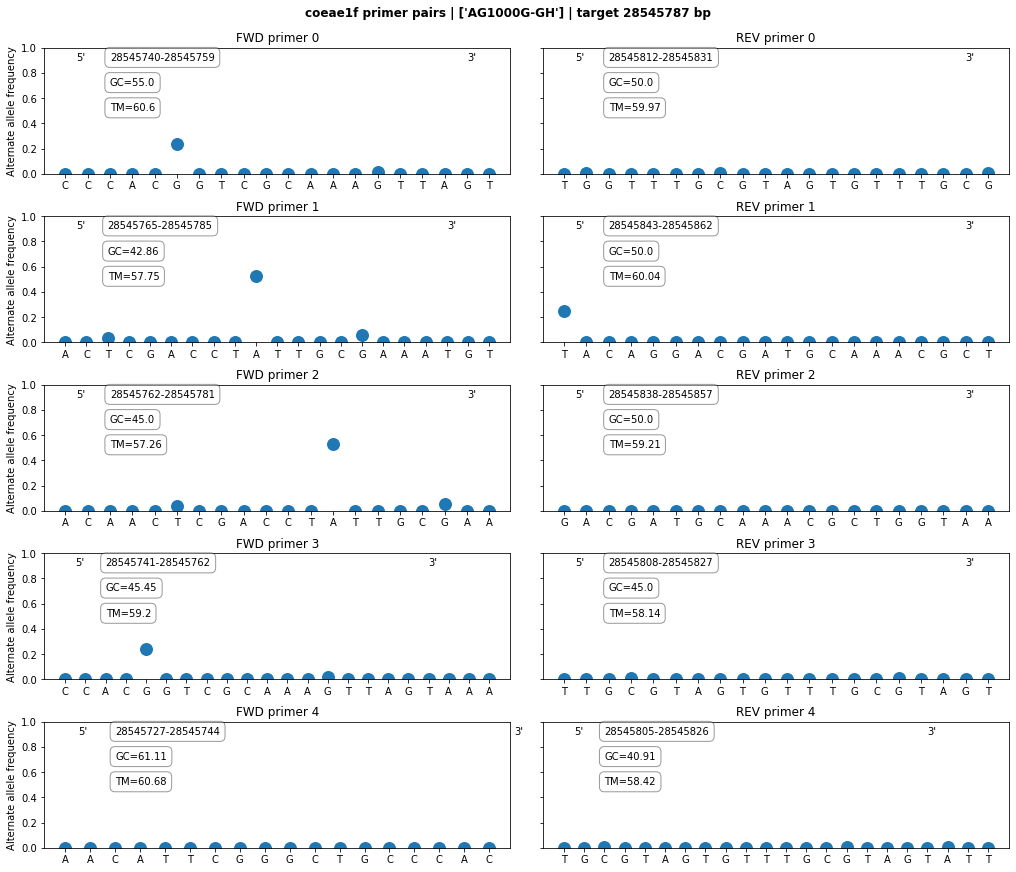

In [ ]:
if assay_type == 'gDNA':
  di_fwd, di_rev = agamPrimer.plot_primer_pairs(primer_df=primer_df, 
                                                gdna_pos=gdna_pos, 
                                                contig=contig,
                                                sample_set=sample_set, 
                                                n_primer_pairs=n_primer_pairs , 
                                                assay=assay_type, 
                                                name=assay_name,
                                                target=target_loc,
                                                save=True) 
elif assay_type == 'qPCR':
  di_fwd, di_rev = agamPrimer.plot_primer_pairs(primer_df=primer_df,
                                                gdna_pos=gdna_pos,
                                                contig=contig,
                                                sample_set=sample_set, 
                                                n_primer_pairs=n_primer_pairs,
                                                assay=assay_type,
                                                name=assay_name, 
                                                target=transcript,
                                                exon_junctions=exon_junctions,
                                                save=True)


Now lets plot these primer pairs across the genome, highlighting where they are in relation to any exons nearby...

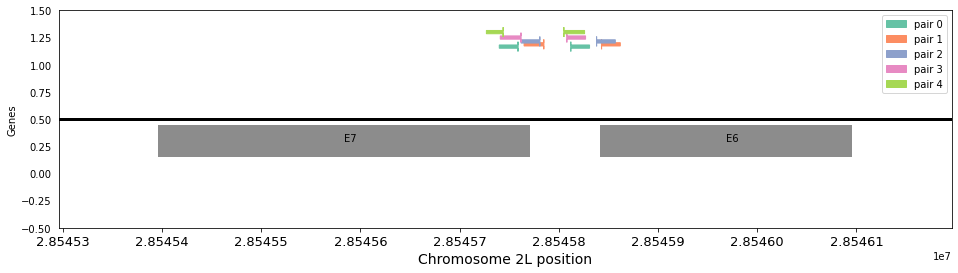

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
if assay_type == 'gDNA':
  agamPrimer.plot_gDNA_primers(gff=ag3.geneset(), contig=contig, start=target_loc-500, end=target_loc+500, n_primer_pairs=n_primer_pairs, ax=ax, di_fwd=di_fwd, di_rev=di_rev)
elif assay_type == 'qPCR':
  agamPrimer.plot_qPCR_primers(gff=ag3.geneset(), transcript=transcript, contig=contig, n_primer_pairs=n_primer_pairs, ax=ax, di_fwd=di_fwd, di_rev=di_rev)

In [ ]:
primer_df

primer_pair,0,1,2,3,4
parameter,,,,,
PRIMER_LEFT_SEQUENCE,CCCACGGTCGCAAAGTTAGT,ACTCGACCTATTGCGAAATGT,ACAACTCGACCTATTGCGAA,CCACGGTCGCAAAGTTAGTAAA,AACATTCGGGCTGCCCAC
PRIMER_RIGHT_SEQUENCE,TGGTTTGCGTAGTGTTTGCG,TACAGGACGATGCAAACGCT,GACGATGCAAACGCTGGTAA,TTGCGTAGTGTTTGCGTAGT,TGCGTAGTGTTTGCGTAGTATT
PRIMER_LEFT_TM,60.601841,57.752994,57.263856,59.198321,60.676471
PRIMER_RIGHT_TM,59.971758,60.037697,59.206139,58.144487,58.422333
PRIMER_LEFT_GC_PERCENT,55.0,42.857143,45.0,45.454545,61.111111
PRIMER_RIGHT_GC_PERCENT,50.0,50.0,50.0,45.0,40.909091
PRIMER_LEFT,"(27, 20)","(52, 21)","(49, 20)","(28, 22)","(14, 18)"
PRIMER_RIGHT,"(118, 20)","(149, 20)","(144, 20)","(114, 20)","(113, 22)"
PRIMER_PAIR_PRODUCT_SIZE,92,98,96,87,100


####**We may now have designed suitable primers. However, there are some further considerations...**


- Primers **must** be run in [**NCBI Blast**](https://blast.ncbi.nlm.nih.gov/Blast.cgi), to ensure specificity against the host organism, and specificity for the genomic location of interest. I would recommend both doing a general blast and also specifically against *An. gambiae* (TaxonID = 7165).

- If in multiplexed use with other primers or probes, primers must not interact with each other. This can be investigated using the IDT tool [oligoanalyzer](https://eu.idtdna.com/calc/analyzer).

- Many more considerations.... [IDT - How to design primers and probes for PCR and qPCR](https://eu.idtdna.com/pages/education/decoded/article/designing-pcr-primers-and-probes)   


  
---


####**Future development**

Any contributions or suggestions on how we can improve this notebook, are more than welcome. Please [email](mailto:sanjay.nagi@lstmed.ac.uk) or log an [issue on github](https://github.com/sanjaynagi/primerDesignAg/issues). This notebook and source code for the agamPrimer functions are located here - https://github.com/sanjaynagi/primerDesignAg/